## Introdução

Este projeto engloba o desafio técnico da Indicium para o programa LightHouse, na trilha de Ciência de Dados.

Para esse notebook, será desenvolvido experimentos do dataset `desafio_indicium_imdb.csv`, para compreender sobre a sua estrutura, limpar, aplicar análise exploratória, técnicas de NLP, engenharia de features, preparar os dados para treinamento e criar/treinar um modelo de Machine Learning com `sckit-learn`.

O objetivo é responder algumas perguntas do desafio e prever a nota IMDB do filme *The Shawshank Redemption*.

### Carregando bibliotecas

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Bibliotecas para NLP
from collections import Counter
import spacy
import re

# Engenharia de Features e Modelagem
from sklearn.preprocessing import MultiLabelBinarizer, RobustScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline

# Avaliação e otimização
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import loguniform

# Ignorando avisos do sistema
import warnings
warnings.filterwarnings('ignore')

# Paleta do cores para todo projeto
cores = "flare"

### Carregando os dados e inspeção inicial

In [195]:
df = pd.read_csv("../data/desafio_indicium_imdb.csv")

In [196]:
print(f"Quantidade de linhas: {df.shape[0]}")
print(f"Quantidade de colunas: {df.shape[1]}")

Quantidade de linhas: 999
Quantidade de colunas: 16


In [197]:
# Visão geral do Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     999 non-null    int64  
 1   Series_Title   999 non-null    object 
 2   Released_Year  999 non-null    object 
 3   Certificate    898 non-null    object 
 4   Runtime        999 non-null    object 
 5   Genre          999 non-null    object 
 6   IMDB_Rating    999 non-null    float64
 7   Overview       999 non-null    object 
 8   Meta_score     842 non-null    float64
 9   Director       999 non-null    object 
 10  Star1          999 non-null    object 
 11  Star2          999 non-null    object 
 12  Star3          999 non-null    object 
 13  Star4          999 non-null    object 
 14  No_of_Votes    999 non-null    int64  
 15  Gross          830 non-null    object 
dtypes: float64(2), int64(2), object(12)
memory usage: 125.0+ KB


Existem algumas features inconsistentens nos dados, como uma coluna sem nome; valores `non-null` abaixo da quantidade de linhas (indicando valores ausentes) nas colunas `Certificate`, `Meta_score`, `Gross`; algumas colunas com Dtype no formato `object` que possívelmente deveria estar como `int` ou `float`.

In [198]:
# Primeiras linhas do Dataframe
df.head()

,Unnamed: 0,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411"
1,2,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444"
2,3,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000"
3,4,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000"
4,5,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905"


### Limpeza dos Dados

Nesta etapa, será removida a coluna "Unnamed" pois se trata apenas de um índice que foi carregado junto aos dados. Em seguida, vamos lidar com duplicatas se necessário e com os valores ausentes.

In [ ]:
df.drop(columns="Unnamed: 0", inplace=True)

In [200]:
print("Contagem de filmes com o mesmo nome:")
df['Series_Title'].value_counts().head()

Contagem de filmes com o mesmo nome:


Series_Title
Drishyam            2
Falling Down        1
Cidade de Deus      1
The Muppet Movie    1
The Warriors        1
Name: count, dtype: int64

Existe apenas um filme com duplicata, o que não irá prejudicar as análises. Um outro ponto importante a se fazer inicialmente, será converter as seguintes colunas para `int`:

- Released_Year

- Runtime (remover ' min')

- Gross (remover vírgulas)

Para isso, será necessário a utilização de técnicas específicas durante a conversão de cada uma dessas colunas.

In [201]:
# Removendo strings
df['Runtime'] = df['Runtime'].str.replace(' min', '')
df['Gross'] = df['Gross'].str.replace(',', '')

# Colunas alvo
conversao_int = ["Released_Year", "Runtime", "Gross"]

# Convertendo para int64
df[conversao_int] = df[conversao_int].apply(pd.to_numeric, downcast='integer', errors='coerce').astype('Int64')

In [202]:
print("Tipos de dados após conversão:")
df.dtypes

Tipos de dados após conversão:


Series_Title      object
Released_Year      Int64
Certificate       object
Runtime            Int64
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross              Int64
dtype: object

In [203]:
print("Contagem de valores nulos por coluna:")
df.isnull().sum()

Contagem de valores nulos por coluna:


Series_Title       0
Released_Year      1
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

As colunas `Released_Year`, `Certificate`, `Meta_score` e `Gross` possuem valores ausentes que precisam de atenção. Mas primeiro, é necessário observar esses dados de perto. Para isso, será usada uma máscara lógica para observar as amostras e decidir a melhor maneira de lidar com esses valores.

In [204]:
# Criando uma máscara lógica com NaNs   
colunas_null = ["Released_Year", "Certificate", "Meta_score", "Gross"]
null_mask = df[colunas_null].isnull()
null_mask[0:5]

,Released_Year,Certificate,Meta_score,Gross
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False


In [205]:
# Filtragem com cinco amostras
linhas_com_null = null_mask.any(axis=1)
df[linhas_com_null].head()

,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
17,Hamilton,2020,PG-13,160,"Biography, Drama, History",8.6,The real life of one of America's foremost fou...,90.0,Thomas Kail,Lin-Manuel Miranda,Phillipa Soo,Leslie Odom Jr.,Renée Elise Goldsberry,55291,<NA>
19,Soorarai Pottru,2020,U,153,Drama,8.6,"Nedumaaran Rajangam ""Maara"" sets out to make t...",NaN,Sudha Kongara,Suriya,Madhavan,Paresh Rawal,Aparna Balamurali,54995,<NA>
29,Seppuku,1962,NaN,133,"Action, Drama, Mystery",8.6,When a ronin requesting seppuku at a feudal lo...,85.0,Masaki Kobayashi,Tatsuya Nakadai,Akira Ishihama,Shima Iwashita,Tetsurô Tanba,42004,<NA>
31,It's a Wonderful Life,1946,PG,130,"Drama, Family, Fantasy",8.6,An angel is sent from Heaven to help a despera...,89.0,Frank Capra,James Stewart,Donna Reed,Lionel Barrymore,Thomas Mitchell,405801,<NA>
45,Hotaru no haka,1988,U,89,"Animation, Drama, War",8.5,A young boy and his little sister struggle to ...,94.0,Isao Takahata,Tsutomu Tatsumi,Ayano Shiraishi,Akemi Yamaguchi,Yoshiko Shinohara,235231,<NA>


Os valores ausentes irão impactar negativamente o desempenho das analises, principalmente a quantidade de NaNs em `Meta_score` e `Gross`. A melhor decisão, será remover esses valores.

In [206]:
df.dropna(inplace=True)

In [207]:
print(f"Quantidade de linhas após remoção de NaNs: {df.shape[0]}\nValores nulos restantes:")
df.isna().sum()

Quantidade de linhas após remoção de NaNs: 712
Valores nulos restantes:


Series_Title     0
Released_Year    0
Certificate      0
Runtime          0
Genre            0
IMDB_Rating      0
Overview         0
Meta_score       0
Director         0
Star1            0
Star2            0
Star3            0
Star4            0
No_of_Votes      0
Gross            0
dtype: int64

## Análise Exploratória de Dados - EDA

In [208]:
df.describe()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
count,712.0,712.0,712.000000,712.000000,7.120000e+02,712.0
mean,1995.738764,123.667135,7.935674,77.154494,3.534662e+05,78450169.183989
std,18.611182,25.907607,0.288928,12.418115,3.464502e+05,115068637.166882
min,1930.0,72.0,7.600000,28.000000,2.522900e+04,1305.0
25%,1986.75,104.0,7.700000,69.750000,9.566475e+04,6143199.0
50%,2001.0,120.0,7.900000,78.000000,2.359815e+05,34850145.5
75%,2010.0,136.0,8.100000,86.000000,5.065428e+05,102360615.0
max,2019.0,238.0,9.200000,100.000000,2.303232e+06,936662225.0


A partir do resumo estatístico da função `describe()` já é possível notar muitos insights interessantes:

- Os filmes estão entre os anos de 1930 à 2019

- Em média, os filmes possuem 2 horas de duração (123 minutos)

- Não temos filmes com uma nota máxima no IMDB, mas temos uma nota bem alta com 9,2

- Filme(s) com um meta score que atingiu 100 pontos

- Título(s) que obteve um alto faturamento, com aproximadamente 930 milhões

A análise exploratória será desenvolvida em subtópicos para responder algumas perguntas e para manter uma organização.

### Recomendação de filme

In [209]:
# Recomendando um filme a partir das features numéricas
col_recomend = ["Series_Title", "Released_Year", "Runtime", "IMDB_Rating", "Meta_score", "No_of_Votes", "Gross"]

df_recomend = df[col_recomend].copy()
df_recomend.sort_values(by=["IMDB_Rating", "No_of_Votes"], ascending=False, inplace=True, ignore_index=True)
df_recomend.head()

,Series_Title,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
0,The Godfather,1972,175,9.2,100.0,1620367,134966411
1,The Dark Knight,2008,152,9.0,84.0,2303232,534858444
2,The Godfather: Part II,1974,202,9.0,90.0,1129952,57300000
3,12 Angry Men,1957,96,9.0,96.0,689845,4360000
4,Pulp Fiction,1994,154,8.9,94.0,1826188,107928762


O filme que seria uma recomendação para uma pessoa, seria o filme **The Dark Knight**. A escolha foi pensada em relação à nota alta do IMDB, o número de votos e o ano de lançamento. O faturamente foi alto, mas isso é influenciado por diversos fatores que vai além dos nossos dados, como a popularidade do "super-herói". Mesmo o filme **The Godfather** estando em primeiro com uma nota excelente e muito bem votado, esse filme foi estreado em 1972 e isso possivelmente não agradaria a maioria das pessoas. Por esse motivo, confirmo a indicação para o filme **The Dark Knight**.

### Análise dos Gêneros

Abaixo, vamos analizar a destribuição de gêneros que temos para descobrir quais são os mais frequentes. Para isso, será necessário dividir os campos separados por virgula e fazer uma contagem unificada, que será observada em um gráfico de barras.

In [210]:
# Preparando os dados para plotagens futuras com os gêneros
df_exploded = df.copy()

df_exploded['Genre'] = df_exploded['Genre'].str.split(', ?')
df_exploded = df_exploded.explode('Genre')
df_exploded['Genre'] = df_exploded['Genre'].str.strip()

# Dados para o top10 de generos
df_genre_counts = df_exploded['Genre'].value_counts().reset_index()
df_genre_counts.columns = ['Genre', 'Count']

# Definindo x, y do plot
generos = df_genre_counts['Genre'].head(10)
contagem = df_genre_counts['Count'].head(10)

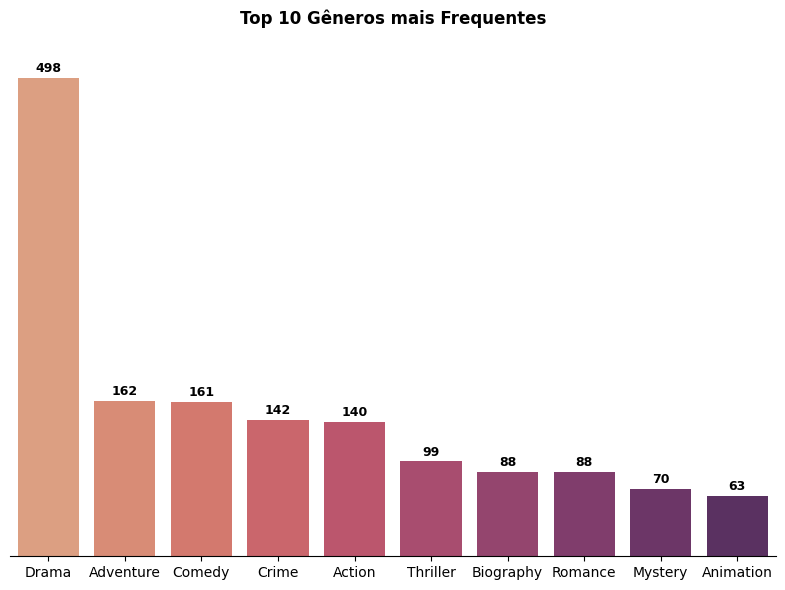

In [211]:
# Gráfico de Barras
plt.figure(figsize=(8,6))
ax = sns.barplot(x=generos, 
                 y=contagem, 
                 palette=cores)

for i in range(len(generos)):
    ax.annotate(f"{contagem[i]:.0f}",
                (i, contagem[i]),
                ha="center",
                xytext=(0, 4),
                textcoords="offset points",
                fontsize=9,
                fontweight="bold")

ax.set_title("Top 10 Gêneros mais Frequentes\n", fontsize=12, fontweight="bold")
ax.set_xlabel("")
ax.set_ylabel("Quantidade de Filmes")

ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.tight_layout()
plt.show()

Podemos observar que o gênero **Drama** é disparado o mais frequente de filmes disponíveis no dataset, seguindo em segunda posição o gênero de **Adventure** com uma **diferença de 207%**. 

Geralmente, os filmes dramáticos costumam ter uma duração mais longa para um melhor aprofundamento dos personagens com uma narrativa mais complexa... mas isso seria mesmo verdade? Para isso, faremos uma análise direcionada aos três primeiros gêneros do top 10.

In [212]:
# Preparando os dados
gen_select = ['Drama', 'Adventure', 'Comedy']
df_boxplot = df_exploded[df_exploded['Genre'].isin(gen_select)]

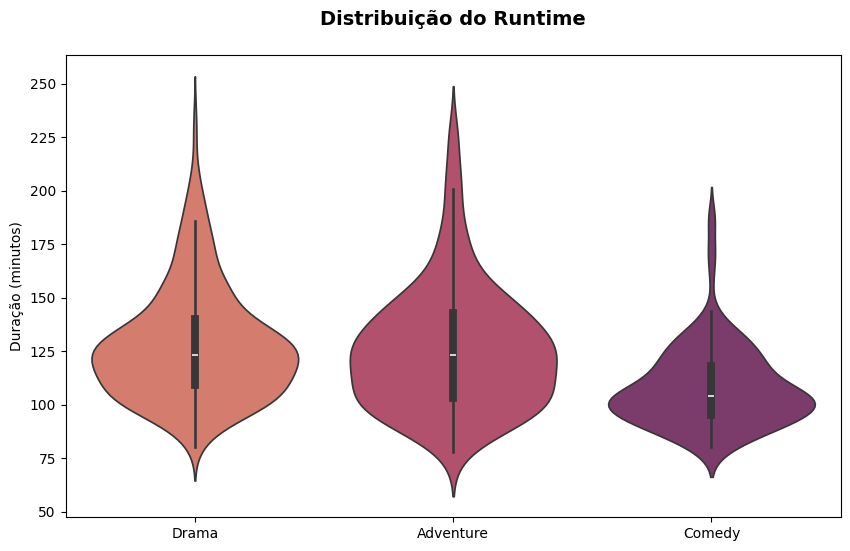

In [213]:
# Plot com
plt.figure(figsize=(10,6))
sns.violinplot(data=df_boxplot,
               x='Genre',
               y='Runtime',
               palette=cores)

plt.title("Distribuição do Runtime\n",fontsize=14, fontweight='bold')
plt.xlabel("")
plt.ylabel("Duração (minutos)")
plt.show()

Analisando o gráfico Violin Plot, podemos observar o "corpo do violino" dos três gêneros. O formato mais largo, indica onde existe uma alta concentração de densidade dos dados.

- **Drama:** A parte mais largas do violino indica uma que os filmes dramáticos possuem em média uma duração de aproximadamente 125 minutos, levando em conta a barra preta no meio, indicando o intervalo interqualtil dos dados (variando de 110 à 140 minutos, aproximadamente). 

- **Adventure:** Possui uma distribuição menos acentuada, com uma duração próxima aos filmes dramáticos com uma tendência à serem mais curtos em sua maior distribuição.

- **Comedy:** Por outro lado, os filmes de comédia possui uma distribuição bastante acentuada, com uma duração de 100 minutos dos filmes.

Podemos concluir que, levando em conta aos filmes do top 10, os dois primeiros da colocação possuem uma duração proxima. Sendo assim, os filmes dramáticos podem ser mais longos que os filmes de aventura e comédia ao observar as distribuições de densidade, mas isso não é generalizável, pois muitos filmes de aventura ainda conseguem ser tão longos quanto.

### Correlação do Faturamento

In [214]:
df_corr = df_recomend.drop(columns='Series_Title')
df_corr.corr()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross
Released_Year,1.000000,-0.017884,-0.178896,-0.272659,0.200074,0.234654
Runtime,-0.017884,1.000000,0.258985,-0.005938,0.213211,0.168775
IMDB_Rating,-0.178896,0.258985,1.000000,0.283994,0.609444,0.132396
Meta_score,-0.272659,-0.005938,0.283994,1.000000,0.028575,-0.014656
No_of_Votes,0.200074,0.213211,0.609444,0.028575,1.000000,0.561532
Gross,0.234654,0.168775,0.132396,-0.014656,0.561532,1.000000


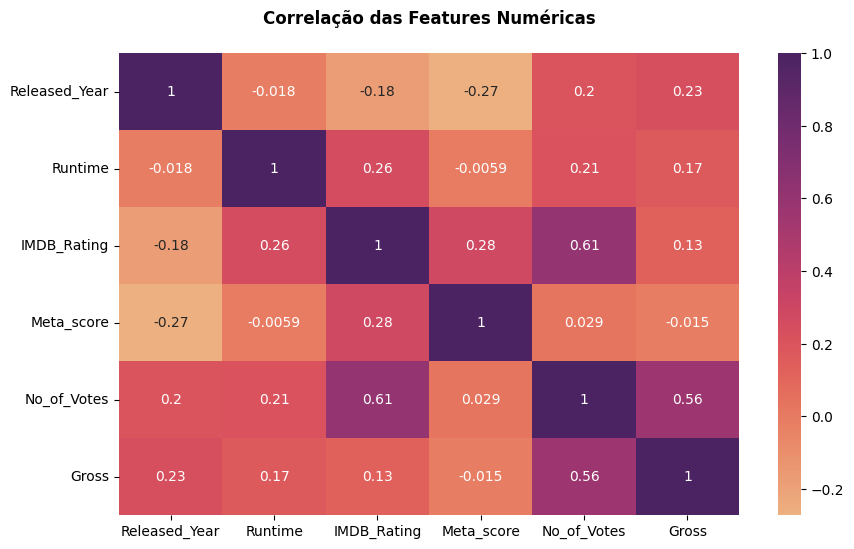

In [215]:
# Representação gráfica
plt.figure(figsize=(10,6))
sns.heatmap(df_corr.corr(),
            annot=True,
            cmap=cores)

plt.title("Correlação das Features Numéricas\n", fontweight='bold')
plt.show()

Analisando o gráfico de calor, podemos ver que existe uma correlação positiva do faturamento `Gross` com o número de votos `No_of_Votes` com `0.56`. É deduzível com esse gráfico que quanto mais o público gosta do filme (votos), mais o filme tende a ser lucrativo. Mas isso é apenas uma análise superficial, pois podem existir mais features que influenciam nesse retorno financeiro.

Deste modo, vamos observar como o faturamento se sai ao levarmos em conta outras features não numéricas.

In [216]:
col_stars = ["Series_Title", "Director", "Star1", "Star2", "No_of_Votes", "Gross"]
df_stars = df[col_stars].copy()

df_stars.sort_values(by=["No_of_Votes", "Gross"], ascending=False, inplace=True, ignore_index=True)
df_stars.head(10)

,Series_Title,Director,Star1,Star2,No_of_Votes,Gross
0,The Dark Knight,Christopher Nolan,Christian Bale,Heath Ledger,2303232,534858444
1,Inception,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,2067042,292576195
2,Fight Club,David Fincher,Brad Pitt,Edward Norton,1854740,37030102
3,Pulp Fiction,Quentin Tarantino,John Travolta,Uma Thurman,1826188,107928762
4,Forrest Gump,Robert Zemeckis,Tom Hanks,Robin Wright,1809221,330252182
5,The Matrix,Lana Wachowski,Lilly Wachowski,Keanu Reeves,1676426,171479930
6,The Lord of the Rings: The Fellowship of the Ring,Peter Jackson,Elijah Wood,Ian McKellen,1661481,315544750
7,The Lord of the Rings: The Return of the King,Peter Jackson,Elijah Wood,Viggo Mortensen,1642758,377845905
8,The Godfather,Francis Ford Coppola,Marlon Brando,Al Pacino,1620367,134966411
9,The Dark Knight Rises,Christopher Nolan,Christian Bale,Tom Hardy,1516346,448139099


Levando em conta que quanto mais o público vota em um filme mais ele tende a lucrar (hipótese), foi passado o `No_of_Votes` como argumento primário durante o `sort.values()`.

Com isso, é possível confirmar que nomes conhecidos, tanto dos diretores quanto das estrelas em `Star1` influenciam fortemente para uma boa margem de lucro de um filme, principalmente do **Christopher Nolan**.

### Insights em Overview

In [217]:
df.loc[0,'Overview']

"An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son."

A coluna "Overview" se trata de uma sinopse para os filmes. Por estar em textos extensos, será necessário aplicar técnicas de Processamento de Linguagem Natural para uma extração mais acertiva de informações e de insights.

Deste modo, será criado uma função para pré-processar o texto e separá-los em tokens a partir de um doc do `spacy`.

In [218]:
# Carregando um modelo leve do spaCy
nlp = spacy.load("en_core_web_sm")

def preprocessador(text):
    """
    Preprocessa um texto reduzindo letras à minúsculas,
    remove números, símbolos e pontuações, 
    normaliza espaços em branco,
    remove stop words e lematiza as palavras.
    Respectivamente.

    Args:
        text (str): O texto a ser pre-processado.

    Returns:
        list: Lista de tokens. Em caso de erro, retorna uma lista vazia.
    """
    try:
        text = text.lower() 
        text = re.sub(r'\d+', '', text)
        text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
        text = re.sub(r'\s+', ' ', text)

        doc = nlp(text)
        tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

        return tokens
       
    except Exception as e:
        print(f"Erro no pre-processamento: {e}")
        return []

In [219]:
# Aplicando a função em uma cópia dos dados
df_pln = df[["Overview", "Genre"]].copy()
df_pln["Overview"] = df_pln["Overview"].apply(preprocessador)

print(f"Texto original: {df.loc[0,'Overview']}")
print(f"Texto Pre-Processado e em Tokens: {df_pln.loc[0,'Overview']}")

Texto original: An organized crime dynasty's aging patriarch transfers control of his clandestine empire to his reluctant son.
Texto Pre-Processado e em Tokens: ['organized', 'crime', 'dynasty', 'age', 'patriarch', 'transfer', 'control', 'clandestine', 'empire', 'reluctant', 'son']


O texo original teve as palavras isoladas (tokens) em uma lista. Foram removidos artigos, preposições, conectivos e varias outras palavras que são redundantes para esse tipo de tarefa. Alguma palavras também foram lematizadas, ou seja, voltaram as suas origens (como "aging" para "age" ou "transfers" para "transfer"). Isso ajuda a normalizar as palavras unificando as que possuem o mesmo valor semântico.

Feito isso, agora podemos iniciar uma contagem das palavras mais frequentes de todo o texto e também de alguns gêneros que serão selecionados.

In [220]:
df_tokens = df_pln.explode("Overview")

# Iniciando contagem
contagem_geral = Counter(df_tokens["Overview"])
print("Palavras mais comuns no dataset inteiro:")
print(contagem_geral.most_common(5))

Palavras mais comuns no dataset inteiro:
[('life', 96), ('young', 91), ('man', 76), ('find', 76), ('world', 65)]


In [221]:
generos_alvo = ["Adventure", "Crime", "Romance"]
contagem_genero = {}

df_tokens["Genre"] = df_tokens["Genre"].astype(str).fillna("")

for gen in generos_alvo:
    tokens_g = df_tokens[df_tokens["Genre"].str.contains(gen, case=False)]["Overview"]
    contagem_genero[gen] = Counter(tokens_g).most_common(5)

for gen, contagem in contagem_genero.items():
    df_tokens = pd.DataFrame(contagem, columns=['Token', 'Frequência'])
    print(f"\nPalavras mais comuns em {gen}:")
    print(df_tokens.to_string(index=False))


Palavras mais comuns em Adventure:
 Token  Frequência
 world          26
 young          23
  find          18
friend          15
   new          14

Palavras mais comuns em Crime:
 Token  Frequência
murder          19
  find          16
  life          15
   man          15
police          15

Palavras mais comuns em Romance:
Token  Frequência
woman          17
 love          16
 life          16
  man          15
young          15


Ao observar cada um dos três gêneros selecionados, podemos tirar conclusões intuitivas a partir do `Overview` e deduzir qual é o seu gênero a apartir das contagens de palavras:

- **Adventure:** Palavras como: world, find, new, friend. traz uma ideia de coisas novas, encontrar coisas em um mundo ou até mesmo fazer amizades.

- **Crime:** Murder, find, police, traz uma ideia de filmes investigativos, com muito mistério envolvido.

- **Romance:** Woman, love, man, traz uma ideia de filmes amorosos e romanticos.

Por fim, é possível deduzir de maneira simples os gêneros dos filmes a partir do `Overview` com contagens de tokens usando um modelo leve do spacy. Para uma confirmação mais precisa, seria necessário utilizar técnicas mais avançadas, ou até mesmo modelos mais robustos como o BERT.

## Previsão de notas IMDB

Existem algumas features categoricas e muitas outras textuais com muitas informações importantes para uma avaliação no IMDB. Se criarmos um modelo baseado apenas nas features numéricas, iriamos perder muito valor. Deste modo, irei precisar aplicar diversas técnicas para transformar esses dados com engenharia de features.

In [222]:
df.columns

Index(['Series_Title', 'Released_Year', 'Certificate', 'Runtime', 'Genre',
       'IMDB_Rating', 'Overview', 'Meta_score', 'Director', 'Star1', 'Star2',
       'Star3', 'Star4', 'No_of_Votes', 'Gross'],
      dtype='object')

In [223]:
# Preparando os dados para o modelo de ML
df_ml = df.drop(columns=["Overview", "Series_Title"])
df_ml.head(2)

,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross
0,1972,A,175,"Crime, Drama",9.2,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,134966411
1,2008,UA,152,"Action, Crime, Drama",9.0,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,534858444


### Engenharia de Features

Analisando o dataframe com os tokens, nota-se que a coluna `Genre` também está presente e isso irá facilitar um pouco à transformar essa coluna categorica em numerica. Para isso, será aplicado uma técnica de binarização mult-label para lidar com os gêneros..

In [224]:
generos = df_ml["Genre"].apply(lambda x: [genero.strip() for genero in x.split(",")])

mlb = MultiLabelBinarizer()
df_generos = pd.DataFrame(mlb.fit_transform(generos),
                          columns=mlb.classes_,
                          index=df.index)
df_generos.iloc[:5,]

,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,...,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western
0,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [225]:
# juntando os dataframes
df_ml = pd.concat([df_ml, df_generos], axis=1)
df_ml.drop(columns="Genre", inplace=True)

In [226]:
# Contando as certificações
counts = df_ml['Certificate'].value_counts()
counts

Certificate
U           182
A           173
UA          142
R           131
PG-13        38
PG           19
G             9
Passed        9
Approved      6
TV-PG         1
U/A           1
GP            1
Name: count, dtype: int64

Para lidar com a feature `Certificate` , vou aplicar o OneHot para binarizar os essas entradas. É notável que existe um grande desbalanceamento nos dados, mas isso será resolvido ao agrupar essas classificações mais raras como "other"

In [227]:
# Definir um limite
limite = 20
rare_class = counts[counts < limite].index

df_ml['Certificate'] = df_ml['Certificate'].replace(rare_class, 'Other')
df_ml['Certificate'].value_counts()

Certificate
U        182
A        173
UA       142
R        131
Other     46
PG-13     38
Name: count, dtype: int64

Ao pesquisar mais afundo, pude notar que as classificações mais relevantes são a partir do PG-13 para cima. Sendo:

- U - Universal

- A - Adulto

- UA - Universal com Supervisão Adulta

- R - Restrito para menores de 17 anos

- PG-13 - Supervisão dos pais para crianças

Ao definir `PG` como `Others` , isso unifica demais classificações que possuem uma contagem baixa, o que poderá melhorar o desempenho do modelo e evitar Overfitting.

A seguir, será aplicado o OneHot com dummies para transformar essa coluna de categórica para numérica.

In [228]:
df_ml = pd.get_dummies(df_ml, columns=['Certificate'], prefix='Cert', dtype=int)

In [229]:
# Visão das primeiras linhas dos dummies
df_ml[["Cert_U", "Cert_A", "Cert_UA", "Cert_R", "Cert_PG-13", "Cert_Other"]].head(2)

,Cert_U,Cert_A,Cert_UA,Cert_R,Cert_PG-13,Cert_Other
0,0,1,0,0,0,0
1,0,0,1,0,0,0


Agora precisamos transformas as últimas features que em tese, podem ser as mais importantes para uma nota do IMDB. As colunas `Director` e as outras `Star`, são fatores de grande peso para atrair públicos, impactar na narrativa e desenvolvimento de um filme, além de trazer reconhecimento aos avaliadores para uma nota elevada. 

Deste modo, será necessário transformar essas features em numéricas. Uma solução acertiva que poderia ser aplicada aqui, é levar em conta ao "histórico" dos atores e dos diretores. Quando um ator ou um diretor possui filmes com boas notas, isso basicamente agrega a sua reputação. Pensando neste raciocínio, será aplicado a média de cada diretor/autor baseado nas notas IMDB e criar novas features a partir disso.

In [230]:
# Features para Director
nota_media_diretor = df_ml.groupby('Director')['IMDB_Rating'].mean()
df_ml['Director_Nota'] = df_ml['Director'].map(nota_media_diretor)

# Features para Star, iterando entre as colunas
for i in range(1, 5):
    col = f"Star{i}"
    nova_col = f"{col}_Nota"

    nota_media_star = df_ml.groupby(col)['IMDB_Rating'].mean()
    df_ml[nova_col] = df_ml[col].map(nota_media_star).fillna(df_ml['IMDB_Rating'].mean())

colunas_drop = ["Director", "Star1", "Star2", "Star3", "Star4"]
df_ml.drop(columns=colunas_drop, inplace=True)

In [231]:
df_ml.head()

,Released_Year,Runtime,IMDB_Rating,Meta_score,No_of_Votes,Gross,Action,Adventure,Animation,Biography,...,Cert_Other,Cert_PG-13,Cert_R,Cert_U,Cert_UA,Director_Nota,Star1_Nota,Star2_Nota,Star3_Nota,Star4_Nota
0,1972,175,9.2,100.0,1620367,134966411,0,0,0,0,...,0,0,0,0,0,8.4000,8.6500,8.300000,9.2,9.100
1,2008,152,9.0,84.0,2303232,534858444,1,0,0,0,...,0,0,0,0,1,8.4625,8.1125,8.350000,9.0,8.275
2,1974,202,9.0,90.0,1129952,57300000,0,0,0,0,...,0,0,0,0,0,8.4000,8.0100,8.566667,8.7,9.100
3,1957,96,9.0,96.0,689845,4360000,0,0,0,0,...,0,0,0,1,0,8.1000,8.5000,9.000000,9.0,9.000
4,2003,201,8.9,94.0,1642758,377845905,1,1,0,0,...,0,0,0,1,0,8.4000,8.8000,8.250000,8.9,8.800


### Modelagem

Para este dataset, queremos descobrir e prever notas IMDB de filmes que o modelo à ser treinado, ainda não conhece. Deste modo, por se tratar de um valor constante e não uma categoria, será utiizado um modelo de **regressão**.

Deste modo, irei dividir os dados em treino e teste.

In [232]:
X = df_ml.drop(columns=["IMDB_Rating"])
y = df_ml["IMDB_Rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Quantidade de dados para treino:", X_train.shape)
print("Quantidade de dados para teste:", X_test.shape)

Quantidade de dados para treino: (569, 37)
Quantidade de dados para teste: (143, 37)


Temos uma quantidade de 569 amostras de treino e 143 dados que serão usados para o teste. Após as engenharias de features, o dataframe alcançou um total de 34 features.

Para este dataset, será criado um pipeline com o modelo de regressão linear em sua versão regularizada, conhecido como `Ridge`. Esse modelo tem um ponto negativo por ser muito sensível a dados em escala, como por exemplo: minutos, segundos, valores de orçamento em milhões e números pequenos como binários. Para isso, será utilizado um scaler para ajudar na performance.

Durante o pipeline, serão aplicadas diversas técnicas para melhorar o desempenho do modelo como:

- **Cálculos estátisticos** aplicados aos parâmetros para percorrer em um intervalo, utilizando `loguniform` para distribuição logarítima dentro de um espaço, o que será muito útil para escolher o `alpha`, já que ele possui números muito pequenos (0,01) e numeros muito grandes em sua magnitude (100).

- **Escalonamento** com `RobustScaler` por lidar bem com outliers. Os outliers não foram removidos pois trazem informações úteis de certos filmes que se beneficiaram de grandes valores (ou o contrário).

- **Otimização de hiperparâmetros** com o `RandomizedSearchCV` para testar diferentes combinações de parâmetros para escolher o ideal a ser usado pelo modelo. Mas ele não irá testar todas as combinações possíveis como o GridSearch, por conta disso será mais rápido.

Os resultados do modelo serão avaliados utilizando como métrica primária o R² e as outras métricas MAE, MSE e RMSE para uma melhor visão dos erros. Essas métricas foram escolhidas pois queremos saber o quanto o modelo irá acertar em suas previsões (com o MAE, MSE e o RMSE por ser mais robusto). E como métrica primaria, o R² irá apresentar em uma porcentagem o quanto nosso modelo poderá explicar as variações de notas IMDB durante as previsões.

In [ ]:
# Treinamento do modelo Ridge
ridge_pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("model", Ridge())
])

ridge_params = {
    "model__alpha": loguniform(0.01, 10),
}

ridge_model = RandomizedSearchCV(ridge_pipeline, ridge_params,
                                  n_iter=100, cv=4, scoring="r2", 
                                  random_state=42, n_jobs=-1)
ridge_model.fit(X_train, y_train)
print("Modelo Ridge treinado.")

Modelo Ridge treinado.


Modelo: Ridge

R²: 0.96
Erro Absoluto Médio (MAE): 0.04
Erro Quadrático Médio (MSE): 0.00
Raiz do Erro Quadrático Médio (RMSE): 0.06

Parâmetro com melhor resultado: {'model__alpha': np.float64(4.588156549160973)}




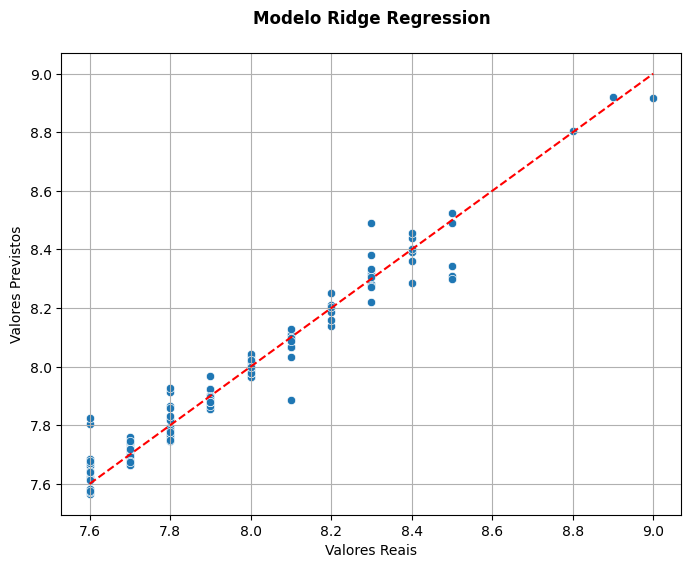

In [234]:
y_pred = ridge_model.predict(X_test)

mae_ridge = mean_absolute_error(y_test, y_pred)
mse_ridge = mean_squared_error(y_test, y_pred)
rmse_ridge = np.sqrt(mse_ridge)
r2_ridge = r2_score(y_test, y_pred)
              
print("Modelo: Ridge\n")
print(f"R²: {r2_ridge:.2f}")
print(f"Erro Absoluto Médio (MAE): {mae_ridge:.2f}")
print(f"Erro Quadrático Médio (MSE): {mse_ridge:.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse_ridge:.2f}")
print(f"\nParâmetro com melhor resultado: {ridge_model.best_params_}")

print("\n")
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valores Reais")
plt.ylabel("Valores Previstos")
plt.title("Modelo Ridge Regression\n", fontweight='bold')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.grid(True)
plt.show()

O modelo atingiu um R² de 0.96, demonstrando que ele é capaz de explicar cerca de **96%** da variação de notas IMDB. Com o MAE em 0.04 e o RMSE em 0.06, indica que o modelo erra poucas avaliações durante suas previsões, sendo assim excelente para aplicar com novas entradas.

### Salvando o modelo

Para salvar o modelo, será necessário estabelecer uma regra de entrada para as futuras previsões com novos dados. Isso é necessário pois nosso modelo foi treinado com mais de 30 features e claramente não teremos a mesma quantidade de entrada. Por isso, vamos estebelecer essa regra se baseando com o dataframe inicial.

In [235]:
#Estabelecendo as features iniciais
features_entrada = df.drop(columns=['IMDB_Rating']).columns.tolist()

salvar_modelo = {
    'pipeline': ridge_model,
    'mlb_generos': mlb,
    'certificate_cols': df_ml.filter(like='Cert_').columns.tolist(),
    'features': df_ml.drop(columns=['IMDB_Rating']).columns.tolist(),
    'media_diretor': nota_media_diretor,
    'media_stars': nota_media_star,
    'media_global': df_ml['IMDB_Rating'].mean()
}

#salvando modelo
path = os.path.abspath("../models/modelo_ridge.pkl")
os.makedirs(os.path.dirname(path), exist_ok=True)

with open(path, 'wb') as arquivo:
    pickle.dump(salvar_modelo, arquivo)
    print(f"Modelo salvo em: {path}")

Modelo salvo em: c:\Users\Thiag\OneDrive\Documentos\Projetos Python\LightHouse-DataScience\models\modelo_ridge.pkl


### Aplicando modelo com novos dados

Abaixo, será elaborada uma extensa função utilizando todas as técnicas utilizadas no notebook para limpeza e engenharia de features. A função basicamente irá unificar todas as linhas que ja foram utilizadas no notebook. A ideia é carregar os dados no formato de dicionário, carregar as colunas do modelo treinado e fazer todas as transformações e engenharias de features, tornando cada coluna equivalente e apropriada para ficar compatível com o modelo.

Em alguns casos, podem existir atores ou até mesmo diretores que o modelo ainda não viu e trazer um valor ausente, e para lidar com isso, vou adicionar a media global para evitar erros e sem enviesar negativamente ou positivamente o resultado.

Apóis isso, será salvado o dicionario em uma versão final em um novo Dataframe para previsão da nota do IMDB

In [ ]:
def prever_nota_filme(filmes, modelo_path=path):
    """
    Recebe um dicionário de filmes
    novos e retorna a nota prevista.
    """
    with open(modelo_path, 'rb') as arquivo:
        modelo = pickle.load(arquivo)
    
    pipeline = modelo['pipeline']
    mlb_generos = modelo['mlb_generos']
    features_entrada = modelo['features']
    media_diretor = modelo['media_diretor']
    media_stars = modelo['media_stars']
    media_global = modelo['media_global']
    
    # Carrega o dicionario
    df_novo = pd.DataFrame([filmes])
    
    # Lidando com as colunas que devem ser numericas
    if 'Runtime' in df_novo.columns:
        df_novo['Runtime'] = df_novo['Runtime'].str.replace(' min', '', regex=False).astype(int)
    if 'Gross' in df_novo.columns:
        df_novo['Gross'] = df_novo['Gross'].str.replace(',', '', regex=False).astype(float)
    if 'Released_Year' in df_novo.columns:
        df_novo['Released_Year'] = pd.to_numeric(df_novo['Released_Year'], errors='coerce').astype('Int64')
    
    # Processando o gênero
    if 'Genre' in df_novo.columns:
        generos_novo = df_novo['Genre'].apply(lambda x: [genero.strip() for genero in x.split(',')])
        df_generos_novo = pd.DataFrame(mlb_generos.transform(generos_novo),
                                       columns=mlb_generos.classes_,
                                       index=df_novo.index)
        df_novo = pd.concat([df_novo, df_generos_novo], axis=1)
        df_novo.drop(columns='Genre', inplace=True)
    
    # obtendo os dummies da faixa etária
    if 'Certificate' in df_novo.columns:
        df_novo = pd.get_dummies(df_novo, columns=['Certificate'], prefix='Cert', dtype=int)
    
    # Nota imdb do diretor
    if 'Director' in df_novo.columns:
        df_novo['Director_Nota'] = df_novo['Director'].map(media_diretor).fillna(media_global)
    
    # Nota imdb dos atores em iteração
    for i in range(1,5):
        col = f'Star{i}'
        nova_col = f'{col}_Nota'
        if col in df_novo.columns and col in media_stars:
            df_novo[nova_col] = df_novo[col].map(media_stars[col]).fillna(media_global)
        else:
            df_novo[nova_col] = media_global
    
    # garantir a existencia das colunas
    for col in features_entrada:
        if col not in df_novo.columns:
            df_novo[col] = 0
    
    # preparando para previsao
    df_novo = df_novo[features_entrada]
    nota_prevista = pipeline.predict(df_novo)
    return nota_prevista


In [ ]:
# Dados do filme alvo para previsão
filme = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years...',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

nota = prever_nota_filme(filme)
print(f"Título do filme: {filme['Series_Title']}")
print(f"Nota IMDB: {nota[0]:.2f}")


Título do filme: The Shawshank Redemption
Nota IMDB: 8.14


### Conclusão

O filme **The Shawkshank Redeption** foi rotulado com uma nota IMDB de **8,14**. O modelo previu uma nota muito boa para esse filme, por mais que ele seja avaliado oficialmente dentro da casa dos nove, o modelo chegou proximo de acertar a previsão. Mesmo não sendo perfeito, podem existir muitas outras features que poderiam tornar o modelo ainda mais robusto, ou até mesmo explorar outros tipos de modelos com otimização de hiperparâmetros e técnicas direcionadas para uma precisão perfeita.

Para o futuro deste projeto, existe a possibilidade de aplicações com diferentes modelos, criação de um script para automatizar a previsão em novos dados a partir de um ponto de extremidade de inferência em tempo real e o enriquecimento do dataset com novas entradas e novas features.